https://www.kaggle.com/competitions/rossmann-store-sales/data?select=store.csv

In [1]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import f_oneway
import pandas as pd
import datetime

In [2]:

import torch
import subprocess

def GPU():
    if torch.cuda.is_available() == True:
        device = 'cuda'
        templist = [1, 2, 3]
        templist = torch.FloatTensor(templist).to(device)
        print("Cuda torch working : ", end="")
        print(templist.is_cuda)
        print("current device no. : ", end="")
        print(torch.cuda.current_device())
        print("GPU device count : ", end="")
        print(torch.cuda.device_count())
        print("GPU name : ", end="")
        print(torch.cuda.get_device_name(0))
        print("device : ", device)
        # Execute the nvidia-smi command using subprocess
        try:
            output = subprocess.check_output(['nvidia-smi']).decode('utf-8')
            print("nvidia-smi output:")
            print(output)
        except (subprocess.CalledProcessError, FileNotFoundError) as e:
            print("Error executing nvidia-smi command:", str(e))
    elif torch.backends.mps.is_available() == True:
        print("Apple device detected\nActivating Apple Silicon GPU")
        device = torch.device("mps")
    else:
        print("cant use gpu , activating cpu")
        device = 'cpu'

    return device
device = GPU()
print(device)

Apple device detected
Activating Apple Silicon GPU
mps


In [17]:
# 데이터 불러오기
try:
    past_sales = pd.read_csv('C:/Users/Administrator/Desktop/딥러닝/rossmann.csv')
    store = pd.read_csv('C:/Users/Administrator/Desktop/딥러닝/store.csv')
except:
    past_sales = pd.read_csv('rossmann.csv')
    store = pd.read_csv('store.csv')

# 데이터 제거
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)

# 데이터 병합
data = pd.merge(left = past_sales,right = store, on = 'Store', how = 'right')

# 날짜
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
data['Month']=pd.DatetimeIndex(data.Date).month
data['Day']=pd.DatetimeIndex(data.Date).day
data = data.drop(['Date'],axis=1)

# 데이터 가공 : StateHoliday
data['StateHoliday'] = data['StateHoliday'].replace({0:'d'}) # 0 값은 d로 대체
data['StateHoliday'] = data['StateHoliday'].replace({'0':'d'})# 0 값은 d로 대체


# 결측값 처리
data = data.dropna(axis=0)

# store 이름 제거
data = data.drop(['Store'],axis=1)

# 데이터 분리(수치형, 범주형)
digital_cols = ['Sales', 'Customers', 'CompetitionDistance', 'Month', 'Day']
digital_data = data[digital_cols]
digital_data = pd.DataFrame(digital_data.values, columns = digital_cols)

# 표준화
scaler = StandardScaler().fit(digital_data)
digital_data = pd.DataFrame(scaler.transform(digital_data),index = digital_data.index, columns = digital_cols)

categorey_clos = data.columns.drop(digital_cols)
categorey_data = data[categorey_clos]
categorey_data = pd.DataFrame(categorey_data.values, columns = categorey_clos)

# 인코딩
onehotencoding_cols = ['StateHoliday', 'StoreType', 'Assortment', 'DayOfWeek']
categorey_data = pd.get_dummies(data = categorey_data, columns = onehotencoding_cols)

# 데이터 병합
data = pd.concat([digital_data, categorey_data], axis = 1)

# 형 통일
data = data.astype({'Promo2':'int', 'StateHoliday_b':'int', 'StateHoliday_c':'int', 'StateHoliday_d':'int', 'StoreType_a':'int', 'StoreType_b':'int', 'StoreType_c':'int', 'StoreType_d':'int'})
data = data.astype({'Assortment_a':'int', 'Assortment_b':'int', 'Assortment_c':'int', 'DayOfWeek_1':'int', 'DayOfWeek_2':'int', 'DayOfWeek_3':'int', 'DayOfWeek_4':'int', 'DayOfWeek_5':'int', 'DayOfWeek_6':'int', 'DayOfWeek_7':'int'})

pd.options.display.max_columns = None
print(data.head(3))
print(past_sales.columns)
print(store.columns)

/var/folders/sb/2gzn9_qx589_ft0jp8q6nbbc0000gn/T/ipykernel_1456/635303137.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  past_sales = pd.read_csv('rossmann.csv')


In [4]:
target_col = 'Sales'
features_cols = data.columns.drop(target_col)
features = data[features_cols]
target = data[target_col]
target = pd.DataFrame(target.values.reshape(-1,1))
features = features.values
target = target.values

In [5]:
# 전체 데이터 중 60%는 학습용 데이터, 20%는 검증용, 20%는 테스트용 데이터 추출
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.4, shuffle=True) #60%
x_test,x_valid,y_test,y_valid = train_test_split(x_test, y_test, test_size=0.5, shuffle=True) #20%/20%

In [6]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_valid = x_valid.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
y_valid = y_valid.astype(np.float32)

In [7]:
print('train_data의 row : %s, column : %s'%(x_train.shape[0],x_train.shape[1]))
print('test_data의 row : %s, column : %s'%(x_test.shape[0],x_test.shape[1]))
print('val_data의 row : %s, column : %s'%(x_valid.shape[0],x_valid.shape[1]))

train_data의 row : 608740, column : 26
test_data의 row : 202913, column : 26
val_data의 row : 202914, column : 26


In [8]:
#Param
Batch = 32 #Batch size
#드랍아웃
DropOut = 0.2 #drop out ratio

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time

# 데이터를 파이토치 Tensor로 변환하고 DataLoader를 만듭니다.
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=Batch)





# Define Model by Class
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(x_train.shape[1], 128),
            nn.ReLU(),
            nn.Dropout(DropOut),
            nn.BatchNorm1d(128)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(DropOut),
            nn.BatchNorm1d(128)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(DropOut),
            nn.BatchNorm1d(128)
        )
        self.layer4 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

model = Model()

In [9]:
# 손실 함수와 옵티마이저를 설정합니다.
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [10]:
from torch.utils.data import TensorDataset, DataLoader

# 데이터를 PyTorch의 Tensor 형식으로 변환합니다.
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_valid = torch.tensor(x_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


# TensorDataset과 DataLoader를 사용하여 데이터를 관리합니다.
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)

BATCH = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

In [11]:
NB_EPOCH = 10

import time

start = time.time()

train_losses = []
val_losses = []

for epoch in range(NB_EPOCH):
    epoch_start = time.time()

    # Training
    total_train_loss = 0.0
    num_train_batches = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        num_train_batches += 1
        
    avg_train_loss = total_train_loss / num_train_batches
    print(f'Epoch {epoch+1} / {NB_EPOCH}, Training Loss: {avg_train_loss}')
    train_losses.append(avg_train_loss)

    # Validation
    with torch.no_grad():
        total_val_loss = 0.0
        num_val_batches = 0
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            num_val_batches += 1

        avg_val_loss = total_val_loss / num_val_batches
        print(f'Epoch {epoch+1} / {NB_EPOCH}, Validation Loss: {avg_val_loss}')
        val_losses.append(avg_val_loss)

    epoch_end = time.time()
    elapsed_time = epoch_end - epoch_start
    remaining_time = (NB_EPOCH - epoch - 1) * elapsed_time
    print('Estimated time left for training: {:.2f} seconds'.format(remaining_time))

end = time.time()
print("Total elapsed time for training: {:.2f} seconds".format(end - start))


Epoch 1 / 10, Training Loss: 0.13320281512328777
Epoch 1 / 10, Validation Loss: 0.11927718540829219
Estimated time left for training: 344.87 seconds
Epoch 2 / 10, Training Loss: 0.11747125432271623
Epoch 2 / 10, Validation Loss: 0.11420934069261439
Estimated time left for training: 304.42 seconds
Epoch 3 / 10, Training Loss: 0.11377117098663535
Epoch 3 / 10, Validation Loss: 0.11678600690005396
Estimated time left for training: 266.98 seconds
Epoch 4 / 10, Training Loss: 0.11107746718915083
Epoch 4 / 10, Validation Loss: 0.11134292648647606
Estimated time left for training: 221.62 seconds
Epoch 5 / 10, Training Loss: 0.10999673436823888
Epoch 5 / 10, Validation Loss: 0.10772121369630774
Estimated time left for training: 186.94 seconds
Epoch 6 / 10, Training Loss: 0.10977457886684334
Epoch 6 / 10, Validation Loss: 0.10840051332961513
Estimated time left for training: 5418.74 seconds
Epoch 7 / 10, Training Loss: 0.10954213068374849
Epoch 7 / 10, Validation Loss: 0.10733505973439089
Estim

In [14]:
torch.save(model.state_dict(), 'store_model.pth')

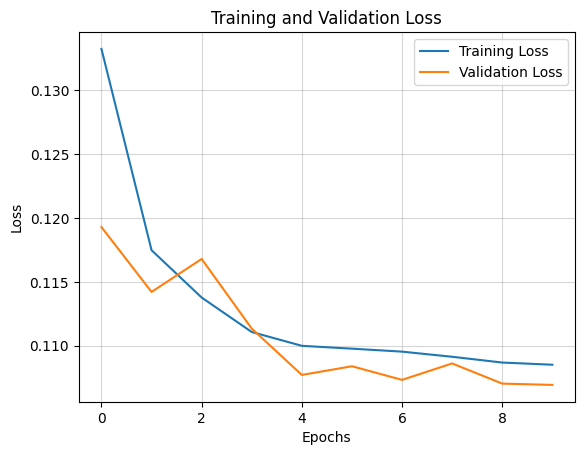

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.grid(True, linestyle='-', alpha=0.5)

# 그래프를 파일로 저장합니다.
plt.savefig('loss_plot.png')

plt.show()


In [13]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256,input_dim = x_train.shape[1],activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',
loss='mae',
metrics=['mean_absolute_error'])

model_path = 'C:/project/rossmann-store-sales'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path , monitor='val_mean_absolute_error', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_mean_absolute_error', patience=10, mode='auto')

history = model.fit(x_train, y_train,
validation_data=(x_valid, y_valid),
batch_size=64,
epochs=50,
callbacks=[checkpoint, early_stopping])
print("\n test accuracy: %.4f" %(model.evaluate(x_test, y_test)[1]))

NameError: name 'tf' is not defined

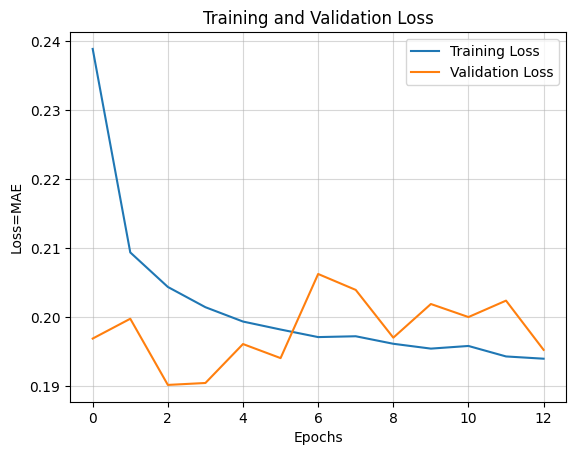

6342/6342 [==============================] - 3s 511us/step - loss: 0.2168 - mean_absolute_error: 0.2168

 test accuracy: 0.2168


In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss=MAE')
plt.legend()

# 그리드 추가
plt.grid(True, linestyle='-', alpha=0.5)

plt.show()
print("\n test accuracy: %.4f" %(model.evaluate(x_test, y_test)[1]))